In [104]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt; plt.rc('font', size=12)
import matplotlib.cm as cm
import seaborn as sns
from scipy.stats import entropy
from scipy.stats import percentileofscore
from scipy.spatial.distance import jensenshannon

In [2]:
taxa = ['B_caccae',
        'B_cellulosilyticus_WH2',
        'B_ovatus',
        'B_thetaiotaomicron',
        'B_uniformis',
        'B_vulgatus',
        'C_aerofaciens',
        'C_scindens',
        'C_spiroforme',
        # 'D_longicatena',
        'P_distasonis',
        'R_obeum'
        ]

pretty_names_dir = {'B_caccae': '$B. caccae$',
                'B_cellulosilyticus_WH2': '$B. cellulosilyticus$',
                'B_ovatus': '$B. ovatus$',
                'B_thetaiotaomicron': '$B. thetaiotaomicron$',
                'B_uniformis': '$B. uniformis$',
                'B_vulgatus': '$B. vulgatus$',
                'C_aerofaciens': '$C. aerofaciens$',
                'C_scindens': '$C. scindens$',
                'C_spiroforme': '$C. spiroforme$',
                # 'D_longicatena': '$D. longicatena$',
                'P_distasonis': '$P. distasonis$',
                'R_obeum': '$R. obeum$'
                }

abbr_names_dir = {'B_caccae': 'Bca',
                'B_cellulosilyticus_WH2': 'Bce',
                'B_ovatus': 'Bov',
                'B_thetaiotaomicron': 'Bth',
                'B_uniformis': 'Bun',
                'B_vulgatus': 'Bvu',
                'C_aerofaciens': 'Cae',
                'C_scindens': 'Csc',
                'C_spiroforme': 'Csp',
                # 'D_longicatena': 'Dlo',
                'P_distasonis': 'Pdi',
                'R_obeum': 'Rob'
                }

pretty_names = [pretty_names_dir[taxa] for taxa in taxa]

## Transformación de las matrices de interacción

In [80]:
def mask_by_bayes(interactions, inter_bayes):
    inter_bayes = inter_bayes.copy()
    interactions = interactions.copy()

    inter_bayes_mask = inter_bayes > np.sqrt(10)
    inter_bayes_mask = inter_bayes_mask.values
    
    interactions_matrix = interactions.values
    interactions_masked = np.ma.masked_array(interactions_matrix, mask=~inter_bayes_mask)
    interactions_masked = interactions_masked.filled(np.nan)
    return interactions_masked

def get_smallest_order_of_magnitude(x):
    return int(np.floor(np.log10(np.nanmin(np.abs(x)))))

# def max_min_swap(x):
#     x = x.copy()
#     x_min = np.nanmin(x)
#     x_max = np.nanmax(x)
#     for i in range(x.shape[0]):
#         for j in range(x.shape[1]):
#             if np.isnan(x[i,j]):
#                 continue
#             x[i,j] = x_max + x_min - x[i,j]
#     return x

# def tranform_interaction_matrix(interactions, inter_bayes):
#     interactions_masked = mask_by_bayes(interactions, inter_bayes)
#     transformed_interaction_matrix = max_min_swap(np.absolute(np.log10(np.absolute(interactions_masked)))) * np.sign(interactions_masked)
#     return transformed_interaction_matrix

def tranform_interaction_matrix(interactions, inter_bayes):
    interactions_masked = mask_by_bayes(interactions, inter_bayes)
    smallest_order_of_magnitude = get_smallest_order_of_magnitude(interactions_masked)
    transformed_interaction_matrix = np.log10(np.abs(interactions_masked * 10**(-1*smallest_order_of_magnitude))) * np.sign(interactions_masked)
    return transformed_interaction_matrix

def shift_to_positive(x):
    x = x.copy()
    C = np.absolute(np.nanmin(x)) + 0.01
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if np.isnan(x[i,j]):
                x[i,j] = 0
            else:
                x[i,j] = x[i,j] + C
    return x

## Cargar matrices ecológicas

In [81]:
inter_bayes_lf0 = pd.read_table('ecological-modeling/mcnulty-results/mcnulty-LF0-seed96/posteriors/interactions/bayes_factors.tsv', index_col=0)
interactions_lf0 = pd.read_table('ecological-modeling/mcnulty-results/mcnulty-LF0-seed96/posteriors/interactions/mean_matrix.tsv', index_col=0)
inter_bayes_hf0 = pd.read_table('ecological-modeling/mcnulty-results/mcnulty-HF0-seed12/posteriors/interactions/bayes_factors.tsv', index_col=0)
interactions_hf0 = pd.read_table('ecological-modeling/mcnulty-results/mcnulty-HF0-seed12/posteriors/interactions/mean_matrix.tsv', index_col=0)
###
eco_lf0 = pd.DataFrame(tranform_interaction_matrix(interactions_lf0, inter_bayes_lf0), 
                                                  index=pretty_names, 
                                                  columns=pretty_names)
eco_hf0 = pd.DataFrame(tranform_interaction_matrix(interactions_hf0, inter_bayes_hf0), 
                                                  index=pretty_names, 
                                                  columns=pretty_names)

## Cargar matrices metabólicas

In [86]:
metabo_ECs_int_lf = pd.read_table('metabolic-modeling/metabolic-metrics/metaddinfo_ECs_int_lf.tsv', index_col=0)
metabo_ECs_int_hf = pd.read_table('metabolic-modeling/metabolic-metrics/metaddinfo_ECs_int_hf.tsv', index_col=0)
metabo_ECs_int_lf_carbo = pd.read_table('metabolic-modeling/metabolic-metrics/metaddinfo_ECs_int_lf_carbo.tsv', index_col=0)
metabo_ECs_int_hf_carbo = pd.read_table('metabolic-modeling/metabolic-metrics/metaddinfo_ECs_int_hf_carbo.tsv', index_col=0)
metabo_ECs_int_lf_amino = pd.read_table('metabolic-modeling/metabolic-metrics/metaddinfo_ECs_int_lf_amino.tsv', index_col=0)
metabo_ECs_int_hf_amino = pd.read_table('metabolic-modeling/metabolic-metrics/metaddinfo_ECs_int_hf_amino.tsv', index_col=0)

## Divergencia de Jensen-Shannon

In [87]:
js_lf0_general = jensenshannon(shift_to_positive(eco_lf0.values).flatten(), metabo_ECs_int_lf.values.flatten())**2
js_hf0_general = jensenshannon(shift_to_positive(eco_hf0.values).flatten(), metabo_ECs_int_hf.values.flatten())**2

js_lf0_carbo = jensenshannon(shift_to_positive(eco_lf0.values).flatten(), metabo_ECs_int_lf_carbo.values.flatten())**2
js_hf0_carbo = jensenshannon(shift_to_positive(eco_hf0.values).flatten(), metabo_ECs_int_hf_carbo.values.flatten())**2

js_lf0_amino = jensenshannon(shift_to_positive(eco_lf0.values).flatten(), metabo_ECs_int_lf_amino.values.flatten())**2
js_hf0_amino = jensenshannon(shift_to_positive(eco_hf0.values).flatten(), metabo_ECs_int_hf_amino.values.flatten())**2

print('Jensen-Shannon divergence for LF0 dataset focusing on general metabolism: ', js_lf0_general)
print('Jensen-Shannon divergence for HF0 dataset focusing on general metabolism: ', js_hf0_general)
print('Jensen-Shannon divergence for LF0 dataset focusing on carbohydrate metabolism: ', js_lf0_carbo)
print('Jensen-Shannon divergence for HF0 dataset focusing on carbohydrate metabolism: ', js_hf0_carbo)
print('Jensen-Shannon divergence for LF0 dataset focusing on amino acid metabolism: ', js_lf0_amino)
print('Jensen-Shannon divergence for HF0 dataset focusing on amino acid metabolism: ', js_hf0_amino)

Jensen-Shannon divergence for LF0 dataset focusing on general metabolism:  0.20317920174370788
Jensen-Shannon divergence for HF0 dataset focusing on general metabolism:  0.16912936269613632
Jensen-Shannon divergence for LF0 dataset focusing on carbohydrate metabolism:  0.18279049786135512
Jensen-Shannon divergence for HF0 dataset focusing on carbohydrate metabolism:  0.1811680909048595
Jensen-Shannon divergence for LF0 dataset focusing on amino acid metabolism:  0.29073308786551566
Jensen-Shannon divergence for HF0 dataset focusing on amino acid metabolism:  0.1974196596145463


## Distancia de Jensen-Shannon

In [92]:
js_lf0_general = jensenshannon(shift_to_positive(eco_lf0.values).flatten(), metabo_ECs_int_lf.values.flatten())
js_hf0_general = jensenshannon(shift_to_positive(eco_hf0.values).flatten(), metabo_ECs_int_hf.values.flatten())

js_lf0_carbo = jensenshannon(shift_to_positive(eco_lf0.values).flatten(), metabo_ECs_int_lf_carbo.values.flatten())
js_hf0_carbo = jensenshannon(shift_to_positive(eco_hf0.values).flatten(), metabo_ECs_int_hf_carbo.values.flatten())

js_lf0_amino = jensenshannon(shift_to_positive(eco_lf0.values).flatten(), metabo_ECs_int_lf_amino.values.flatten())
js_hf0_amino = jensenshannon(shift_to_positive(eco_hf0.values).flatten(), metabo_ECs_int_hf_amino.values.flatten())

print('Jensen-Shannon divergence for LF0 dataset focusing on general metabolism: ', js_lf0_general)
print('Jensen-Shannon divergence for HF0 dataset focusing on general metabolism: ', js_hf0_general)
print('Jensen-Shannon divergence for LF0 dataset focusing on carbohydrate metabolism: ', js_lf0_carbo)
print('Jensen-Shannon divergence for HF0 dataset focusing on carbohydrate metabolism: ', js_hf0_carbo)
print('Jensen-Shannon divergence for LF0 dataset focusing on amino acid metabolism: ', js_lf0_amino)
print('Jensen-Shannon divergence for HF0 dataset focusing on amino acid metabolism: ', js_hf0_amino)

Jensen-Shannon divergence for LF0 dataset focusing on general metabolism:  0.45075403685791643
Jensen-Shannon divergence for HF0 dataset focusing on general metabolism:  0.411253404479691
Jensen-Shannon divergence for LF0 dataset focusing on carbohydrate metabolism:  0.42754005410178253
Jensen-Shannon divergence for HF0 dataset focusing on carbohydrate metabolism:  0.42563845092385566
Jensen-Shannon divergence for LF0 dataset focusing on amino acid metabolism:  0.5391967060966857
Jensen-Shannon divergence for HF0 dataset focusing on amino acid metabolism:  0.4443193216759162


In [108]:
js_table = pd.DataFrame({'LF0':[js_lf0_general, js_lf0_carbo, js_lf0_amino], 'HF0':[js_hf0_general, js_hf0_carbo, js_hf0_amino]}, index=['General', 'Carbohydrates', 'Amino acids'])

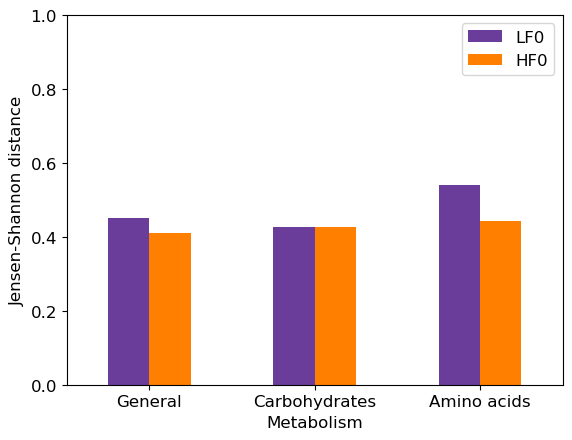

In [109]:
js_table.plot(kind='bar', rot=0, color=[cm.Paired(9), cm.Paired(7)])
plt.ylim(0, 1)
plt.ylabel('Jensen-Shannon distance')
plt.xlabel('Metabolism')
plt.show()